<a href="https://colab.research.google.com/github/purbid/semantic-segmentation/blob/master/bert_baseline_rhetoric_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install transformers

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [5]:
device

device(type='cuda')

In [6]:
###### load the text files and crate df for training and testing
data_list=[]
labels_list=[]
labels_to_id_mapping={
    'Facts': 0, 
    'Argument' : 1, 
    'Ratio of the decision' : 2, 
    'Statute' : 3,
    'Ruling by Present Court' : 4, 
    'Ruling by Lower Court' : 5,
    'Precedent' : 6
}
import os
dir_path = "/content/drive/MyDrive/text/"
for filename in os.listdir(dir_path):
  f = os.path.join(dir_path, filename)
  print(f)
  # checking if it is a file
  if os.path.isfile(f):
      with open(f) as file:
        lines = file.readlines()
        lines = [line.rstrip() for line in lines]
        data_list.extend([sent.split("\t")[0] for sent in lines])
        labels_list.extend([labels_to_id_mapping[sent.split("\t")[-1]] for sent in lines])

        file.close()

/content/drive/MyDrive/text/1977_P_19.txt
/content/drive/MyDrive/text/2014_J_33.txt
/content/drive/MyDrive/text/1987_M_123.txt
/content/drive/MyDrive/text/2011_I_16.txt
/content/drive/MyDrive/text/2011_S_308.txt
/content/drive/MyDrive/text/2009_B_16.txt
/content/drive/MyDrive/text/2008_S_549.txt
/content/drive/MyDrive/text/2014_R_41.txt
/content/drive/MyDrive/text/2004_C_129.txt
/content/drive/MyDrive/text/2009_S_146.txt
/content/drive/MyDrive/text/2008_C_166.txt
/content/drive/MyDrive/text/2001_A_234.txt
/content/drive/MyDrive/text/2007_C_121.txt
/content/drive/MyDrive/text/1996_T_169.txt
/content/drive/MyDrive/text/1953_L_1.txt
/content/drive/MyDrive/text/2001_S_1131.txt
/content/drive/MyDrive/text/2015_S_368.txt
/content/drive/MyDrive/text/1973_S_68.txt
/content/drive/MyDrive/text/2008_S_1411.txt
/content/drive/MyDrive/text/2015_J_10.txt
/content/drive/MyDrive/text/1971_S_1.txt
/content/drive/MyDrive/text/2007_S_608.txt
/content/drive/MyDrive/text/2010_S_431.txt
/content/drive/MyDri

In [7]:
df = pd.DataFrame()
df["sent"]=data_list
df["labels"]=labels_list

In [8]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['sent'], df['labels'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['labels'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [9]:
bert = AutoModel.from_pretrained('nlpaueb/legal-bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('nlpaueb/legal-bert-base-uncased')

Downloading:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at nlpaueb/legal-bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/222k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

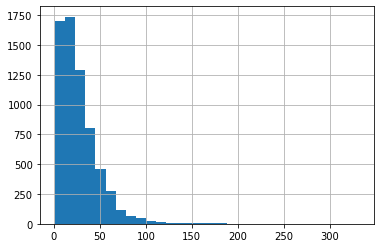

In [10]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [22]:
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 100,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 100,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 100,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [23]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [24]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [25]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512, 7)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x


# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [29]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)    
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.60399227 1.58445946 0.36972803 2.07522124 5.12568306 4.24434389
 0.91245136]


In [30]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 100

In [31]:
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        
    # get model predictions for the current batch
    preds = model(sent_id, mask)


    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [32]:
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 100
  Batch    50  of    206.
  Batch   100  of    206.
  Batch   150  of    206.
  Batch   200  of    206.

Evaluating...

Training Loss: 1.971
Validation Loss: 1.921

 Epoch 2 / 100
  Batch    50  of    206.
  Batch   100  of    206.
  Batch   150  of    206.
  Batch   200  of    206.

Evaluating...

Training Loss: 1.914
Validation Loss: 1.893

 Epoch 3 / 100
  Batch    50  of    206.
  Batch   100  of    206.
  Batch   150  of    206.
  Batch   200  of    206.

Evaluating...

Training Loss: 1.878
Validation Loss: 1.845

 Epoch 4 / 100
  Batch    50  of    206.
  Batch   100  of    206.
  Batch   150  of    206.
  Batch   200  of    206.

Evaluating...

Training Loss: 1.844
Validation Loss: 1.837

 Epoch 5 / 100
  Batch    50  of    206.
  Batch   100  of    206.
  Batch   150  of    206.
  Batch   200  of    206.

Evaluating...

Training Loss: 1.817
Validation Loss: 1.912

 Epoch 6 / 100
  Batch    50  of    206.
  Batch   100  of    206.
  Batch   150  of    206.
  Batc

In [20]:
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()
  
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.48      0.64      0.54       333
           1       0.27      0.29      0.28       126
           2       0.71      0.09      0.17       543
           3       0.16      0.82      0.27        97
           4       0.26      0.60      0.36        40
           5       0.12      0.06      0.08        48
           6       0.46      0.30      0.36       220

    accuracy                           0.34      1407
   macro avg       0.35      0.40      0.30      1407
weighted avg       0.51      0.34      0.31      1407

